Import Library

In [ ]:
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

import joblib

Load sumberdaya dan pendefinisian fungsi preprocessing untuk dataset model pelatihan

LINK REFERENSI
stopwords : https://github.com/stopwords-iso/stopwords-id/blob/master/stopwords-id.txt
kamus leksikon : https://github.com/onpilot/sentimen-bahasa/tree/master
kamus bahasa indonesia : https://github.com/damzaky/kumpulan-kata-bahasa-indonesia-KBBI/blob/master/list_1.0.0.txt
kamus slang : https://github.com/nasalsabila/kamus-alay/blob/master/colloquial-indonesian-lexicon.csv

In [1]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(file.read().splitlines())
    
def load_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(json.load(file))  
    
slang_dict = json.load(open("txt/kamusSlang.json", "r", encoding="utf-8"))
stopwords = load_file('txt/stopwords-1.txt')
kamus_indonesia = load_file('txt/kamusIndonesia.txt')
pos_lexicon = load_lexicon('leksikon/leksikon-pos.json')
neg_lexicon = load_lexicon('leksikon/leksikon-neg.json')

def preprocessing(text, slang_dict, stopwords, kamus_indonesia, stemmer):
    text = text.lower()  # Case folding
    text = re.sub(r"\\t|\\n|\\u|\\|http[s]?://\\S+|[@#][A-Za-z0-9_]+", " ", text)  # Menghapus karakter khusus
    text = re.sub(r"\\d+", "", text)  # Menghapus angka
    text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca (pakai import string)
    text = re.sub(r"\\s+", ' ', text).strip()  # merapihkan spasi ganda
    text = re.sub(r"\b[a-zA-Z]\b", "", text) # Menghapus satu huruf (besar/kecil)
    text = ' '.join([slang_dict.get(word, word) for word in text.split()]) # Normalisasi (pemanfaatan kamus slang)
    text = word_tokenize(text) # Tokenisasi (sebelum stemming)
    text = [stemmer.stem(word) for word in text] # Stemming
    text = [word for word in text if word not in stopwords and len(word) > 3 and word in kamus_indonesia] # Stopwords & memilah kata
    text = ' '.join(text)
    return text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Fungsi pelabelan sentimen (boleh diskip)

In [2]:
def hitung_sentimen(text, leksikon_positif, leksikon_negatif, prior_positif=0.5, prior_negatif=0.5):
    # Inisialisasi skor total
    total_skor_positif = 0
    total_skor_negatif = 0

    # Iterasi seluruh kata pada teks (kalimat)
    for kata in text.split():
        # Hitung P(kata|positif) dan P(kata|negatif)
        probabilitas_kata_positif = 1 / len(leksikon_positif) if kata in leksikon_positif else 0
        probabilitas_kata_negatif = 1 / len(leksikon_negatif) if kata in leksikon_negatif else 0

        # Jumlah skor kata
        total_skor_kata = probabilitas_kata_positif + probabilitas_kata_negatif

        # Perhitungan skor sentimen positif dan negatif untuk kata
        skor_sentimen_positif = probabilitas_kata_positif / total_skor_kata if total_skor_kata > 0 else 0
        skor_sentimen_negatif = probabilitas_kata_negatif / total_skor_kata if total_skor_kata > 0 else 0

        # Akumulasi skor
        total_skor_positif += skor_sentimen_positif
        total_skor_negatif += skor_sentimen_negatif

    # Hitung total skor semua kata
    total_skor_semua = total_skor_positif + total_skor_negatif

    # Hitung probabilitas akhir untuk positif dan negatif
    probabilitas_positif = ((total_skor_positif / total_skor_semua) * prior_positif) if total_skor_semua > 0 else 0
    probabilitas_negatif = ((total_skor_negatif / total_skor_semua) * prior_negatif) if total_skor_semua > 0 else 0

    # Tentukan sentimen berdasarkan probabilitas tertinggi
    if probabilitas_positif > probabilitas_negatif:
        return 'Positif', 1
    elif probabilitas_negatif > probabilitas_positif:
        return 'Negatif', -1
    else:
        return 'Netral', 0

Pemanggilan fungsi preprocessing

In [3]:
df = pd.read_csv('code_filter_crawling/crawling.csv')
df.rename(columns={"full_text" : "teks"}, inplace=True)
df['teks'] = df['teks'].apply(lambda x: preprocessing(x, slang_dict, stopwords, kamus_indonesia,stemmer))

df.to_csv('preprocessing/preprocessing.csv', index=False)
df = df[df['teks'].str.strip().astype(bool)]

Pemanggilan fungsi pelabelan (boleh di skip)

In [ ]:
df[['label' ,'skor']] = df['teks'].apply(lambda x: pd.Series(hitung_sentimen(x, pos_lexicon, neg_lexicon)))
df = df[df['teks'].str.strip().astype(bool)]
df.to_csv('dataset_berlabel/dataset_berlabel.csv', index=False)

Pelatihan model logistic regression (tanpa SMOTE)

In [4]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score
# from imblearn.over_sampling import SMOTE

# data = pd.read_csv('dataset_berlabel/dataset_berlabel.csv')

# # Preprocessing teks (case folding, tokenization, dsb.) bisa dilakukan di sini
# # data['teks'] = data['teks'].apply(lambda x: preprocessing(x, slang_dict, stopwords, kamus_indonesia, stemmer))

# X = data['teks']
# y = data['label']


# # Membagi data menjadi training dan testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# vectorizer = TfidfVectorizer()


# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)


# # Melatih model Logistic Regression
# model = LogisticRegression()
# model.fit(X_train_tfidf, y_train)

# # Memprediksi hasil untuk data testing
# y_pred = model.predict(X_test_tfidf)

# # Evaluasi model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


Pelatihan model logistic regression (menggunakan SMOTE) proporsi split data 70:30

In [5]:
import pandas as pd
df = pd.read_csv('dataset_berlabel/dataset_berlabel.csv')
X = df['teks']
y = df['label']
smote = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test_tfidf)

joblib.dump(model, "model/model_sentimen.pkl")
joblib.dump(vectorizer, "model/vectorizer_sentimen.pkl")

print("akurasi:", accuracy_score(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))


akurasi: 0.8343023255813954
classification report:
               precision    recall  f1-score   support

     Negatif       0.86      0.89      0.87       208
      Netral       0.36      0.29      0.32        14
     Positif       0.83      0.80      0.82       122

    accuracy                           0.83       344
   macro avg       0.68      0.66      0.67       344
weighted avg       0.83      0.83      0.83       344



Confusion Matrix pada model logistic regression

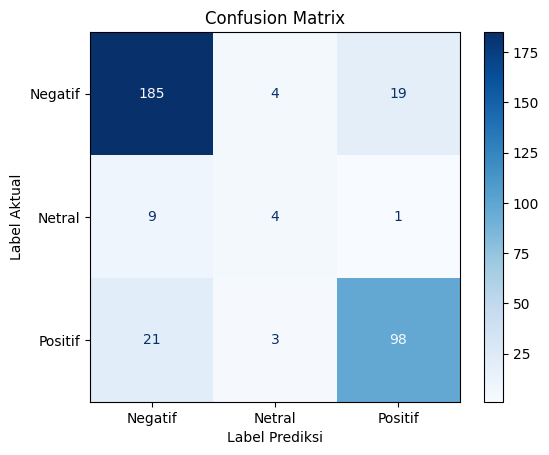

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.xlabel("Label Prediksi")  # Mengganti label sumbu x
plt.ylabel("Label Aktual")    # Mengganti label sumbu y
plt.title("Confusion Matrix") # Menambahkan judul pada plot

# Menampilkan plot

plt.show()


Presisi, recall dan f1-score secara keseluruhan (dihitung dari average macro)

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Menghitung presisi, recall, dan F1-score secara keseluruhan
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Presisi (keseluruhan): {precision:.2f}")
print(f"Recall (keseluruhan): {recall:.2f}")
print(f"F1-Score (keseluruhan): {f1:.2f}")


Presisi (keseluruhan): 0.68
Recall (keseluruhan): 0.66
F1-Score (keseluruhan): 0.67


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1144 non-null   object
 1   label   1144 non-null   object
 2   skor    1144 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 26.9+ KB
